Notebook initialization:

You need to run the next 3 cells!

In [1]:
# import necessary modules
# uncomment to get plots displayed in notebook
%matplotlib notebook
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from classy_sz import Class
from scipy.optimize import fsolve
from scipy.interpolate import interp1d
import math
from astropy.io import fits
import pandas as pd

import uncertainties as un
from uncertainties import unumpy

from scipy.optimize import fmin


font = {'size'   : 16, 'family':'STIXGeneral'}
axislabelfontsize='large'
matplotlib.rc('font', **font)
matplotlib.mathtext.rcParams['legend.fontsize']='medium'
plt.rcParams["figure.figsize"] = [8.0,6.0]

Common settings for cosmological parameters and other CLASS parameters

In [2]:
common_settings = {
                   'output':'tCl,pCl,lCl',
                   # LambdaCDM parameters
                   'h':0.67556,
                   'omega_b':0.022032,
                   'omega_cdm':0.12038,
                   'A_s':2.215e-9,
                   'tau_reio':0.0925,
                   # Take fixed value for primordial Helium (instead of automatic BBN adjustment)
                   'YHe':0.246,
                   'mass function' : 'T10',
                   'integrate_wrt_m200m' : 1
}


p18_cosmo = {
    
     # P18 1st column table 1 of https://arxiv.org/pdf/1807.06209.pdf
    'omega_b': 0.022383,
    'omega_cdm': 0.12011,
    'h': 0.6732,
    'tau_reio': 0.0543,
    'ln10^{10}A_s': 3.0448,
    'n_s': 0.96605,
    'k_pivot': 0.05,
    'N_ncdm': 1,
    'N_ur': 2.0328,
    'm_ncdm': 0.06
}
factor_sz = 1e-2

In [3]:
# copied from : https://github.com/simonsobs/websky_model/blob/a93bbf758432a936c0ec2b59775683b695d3d191/websky_model/websky.py#L55
websky_Omega_M = 0.31
websky_Omega_B = 0.049
websky_Omega_L = 0.69
websky_h = 0.68
websky_sigma_8 = 0.81
websky_n_s = 0.965


websky_cosmo = {
    'omega_b': websky_Omega_B*websky_h**2.,
    'omega_cdm': (websky_Omega_M-websky_Omega_B)*websky_h**2.,
    'h': websky_h,
    'tau_reio': 0.0543,
    'sigma8': websky_sigma_8,
    'n_s': websky_n_s,   
}


omegab = websky_Omega_B
omegac = websky_Omega_M-websky_Omega_B
omegam = omegab + omegac
h      = websky_h
ns     = websky_n_s
sigma8 = websky_sigma_8

c = 3e5

H0 = 100*h
nz = 100000
z1 = 0.0
z2 = 6.0
za = np.linspace(z1,z2,nz)
dz = za[1]-za[0]

H      = lambda z: H0*np.sqrt(omegam*(1+z)**3+1-omegam)
dchidz = lambda z: c/H(z)

chia = np.cumsum(dchidz(za))*dz

zofchi = interp1d(chia,za)

In [22]:
M = Class()
M.set(websky_cosmo)
has_selfn = 1
snrcut = 6.5
M.set({
          'non linear': 'halofit',
#           'output' :'sz_cluster_counts,m200m_to_m500c',
          'output' :'sz_cluster_counts',#,m200m_to_m500c',
          'mass function' : 'M500',
#     'mass function' : 'T08',
    
#           'integrate_wrt_m500c' : 1,
          'concentration parameter': 'B13',
          'has_selection_function' : has_selfn,
          'sky area in deg2': 41253.,
#     'sky area in deg2': 599.,
          'experiment' : 1, # simons observatory 1
          'y_m_relation' : 1,
          'signal-to-noise cut-off for survey cluster completeness' : snrcut,
#           'SO_skyfracs_file': "/sz_auxiliary_files/so_3freqs_120921_pass2_skyfracs.txt",
#           'SO_ylims_file': "/sz_auxiliary_files/so_3freqs_120921_pass2_ylims.txt",
#           'SO_thetas_file': "/sz_auxiliary_files/so_3freqs_120921_pass2_thetas.txt",

          'M_min' : 1e14,#*websky_h, # bounds in websky m200m:8.06216e+13 2.35569e+15
          'M_max' : 5e15,
          'B': 1.,

          'N_ur': 2.0328,
          'N_ncdm': 1,
          'm_ncdm': 0.0,
          'T_ncdm': 0.71611,
          'input_verbose' : 0,
          'background_verbose': 0,
          'perturbations_verbose': 0,
          'sz_verbose'  : 0,

          'bin_z_min_cluster_counts' : 0.,
          'bin_z_max_cluster_counts' : 2.,
          'bin_dz_cluster_counts' : 0.1,
          'bin_dlog10_snr': 0.25,

          'dlny' : 0.02,
          'lnymin' : -11., # planck  -11.5 so -11
          'lnymax' : -5.,  # planck 10. so -5
          'dlnM_cluster_count_completeness_grid' : 0.02,


          'cluster_count_completeness_grid_z_cutoff_low' : 0.2,
          'cluster_count_completeness_grid_z_cutoff_mid' : 1.,

          'dz_cluster_count_completeness_grid_low_z' : 1e-3,
          'dz_cluster_count_completeness_grid_mid_z' : 1e-2,
          'dz_cluster_count_completeness_grid_high_z' : 1e-1,



          'mass_epsrel_cluster_counts' : 1e-6,
          'mass_epsabs_cluster_counts' : 1e-40,

          'redshift_epsrel_cluster_counts' : 1e-4,
          'redshift_epsabs_cluster_counts' : 1e-40,
    
          'A_ym': 4.35e-05,#4.68912e-05,#4.35e-05,#4.62e-05,#A_ym_websky,4.68912e-05 b=1.054969e+00
          'B_ym':0.08,#5.496869e-02, #0.08, #B_ym_websky,
          'C_ym' : 0.,
          'sigmaM_ym' : 0.,
    

#           # # tabulation of mass function:
          'n_z_dndlnM' : 200,
          'n_m_dndlnM' : 200,
#           #
#           # # computation of mass function
#           # # (grid in mass and redshifts for sigma and dsigma)
          'ndim_masses' : 200,
          'ndim_redshifts' : 200,

#           # pk setup for computation of sigma and dsigma
    
          'k_per_decade_class_sz' : 40., #important parameter
          'k_min_for_pk_class_sz' : 1e-4,
          'k_max_for_pk_class_sz' : 10.,

          'P_k_max_h/Mpc' : 2e1
    
})
M.compute()
print(M.sigma8())
print(M.get_sigma8_at_z(0.0002))
# print(M.get_sigma8_at_z(0.0))

0.8100000957137263
0.8103068145505946


In [23]:
dNdzdy_theoretical = M.dndzdy_theoretical()['dndzdy']
z_center = M.dndzdy_theoretical()['z_center']
z_edges = M.dndzdy_theoretical()['z_edges']
log10y_center = M.dndzdy_theoretical()['log10y_center']
log10y_edges = M.dndzdy_theoretical()['log10y_edges']
# M.struct_cleanup()
# M.empty()

In [24]:
np.sum(dNdzdy_theoretical)

27096.322175781734

In [9]:
#m200ms = np.geomspace(1e12,1e15)
#m500ms = np.vectorize(M.get_m200m_to_m500c_at_z_and_M)(1e-5,m200ms)

In [10]:
N_z,N_y = np.shape(dNdzdy_theoretical)
N_clusters_z_theory = []
N_clusters_z_theory_actlike = []
# N_clusters_z_theory_plancklike = []
for iz in range(N_z):
    if (has_selfn == 1):
        N_clusters_z_theory.append(np.sum(dNdzdy_theoretical[iz]))
    elif (has_selfn == 0):
        N_clusters_z_theory.append(dNdzdy_theoretical[iz][0])
#     N_clusters_z_theory_actlike.append(np.sum(dNdzdy_theoretical[iz])/4.)
#     N_clusters_z_theory_plancklike.append(np.sum(dNdzdy_theoretical[iz])/25.)
N_clusters_y_theory = []
for iy in range(N_y):
    N_clusters_y_theory.append(np.sum(np.asarray(dNdzdy_theoretical)[:,iy]))




In [11]:
np.sum(N_clusters_z_theory)

27096.322175781734

In [12]:
# here puth the path to the directory : MFMF_SOSim_3freq_tiles
# path_to_catalogue = '/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz_external_data_and_scripts/MFMF_SOSim_3freq_tiles/'
# path_to_catalogue = '/Users/boris/Work/CLASS-SZ/SO-SZ/so_cluster_counts/MFMF_WebSkyHalos_A10tSZ_3freq_tiles/'
path_to_catalogue = '/Users/boris/Work/CLASS-SZ/SO-SZ/so_cluster_counts/MFMF_WebSkyHalos_A10tSZ_3freq_tiles_pass2/MFMF_WebSkyHalos_A10tSZ_3freq_tiles/'

#"fits_image_filename = fits.util.get_testdata_filepath(path_to_catalogue+'MFMF_SOSim_3freq_tiles_M500.fits')
tcat = path_to_catalogue+'MFMF_WebSkyHalos_A10tSZ_3freq_tiles_mass.fits'
# tcat = path_to_catalogue+'WebSky_A10_mock.fits'
# tcat = path_to_catalogue+'MFMF_WebSkyHalos_A10tSZ_3freq_tiles_optimalCatalog.fits'
list = fits.open(tcat)
data = list[1].data
z = data.field("redshift")
snr = data.field("fixed_SNR")
# snr = np.sqrt(snr**2-3.)
tile = data.field("tileName")

z = z[snr > snrcut]
# snr = np.sqrt(snr[snr > snrcut]**2-3.)
snr = snr[snr > snrcut]
sf = np.loadtxt('/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz/sz_auxiliary_files/so_3freqs_120921_pass2_skyfracs.txt')
print('sky fraction:',sf.sum())
print('area:',sf.sum()*41253.)
print('N clusters:',z.size,snr.size)

sky fraction: 0.43353265345590863
area: 17884.5225530166
N clusters: 21252 21252


In [13]:
from nemo import *
path_to_selfn = '/Users/boris/Work/CLASS-SZ/SO-SZ/so_cluster_counts/MFMF_WebSkyHalos_A10tSZ_3freq_tiles_pass2/MFMF_WebSkyHalos_A10tSZ_3freq_tiles_pass2/selFn/'


configFileName=path_to_selfn+'config.yml'
selFnDir=path_to_selfn
SNRCut=6.5
zStep=0.1
footprintLabel=None

print(">>> Setting up SNR > %.2f selection function ..." % (SNRCut))
selFn=completeness.SelFn(selFnDir, SNRCut, configFileName = configFileName, 
                         footprintLabel = footprintLabel, zStep = zStep)

scalingRelationDict=selFn.scalingRelationDict
H0, Om0, Ob0, sigma8, ns = websky_h*100., websky_Omega_M,websky_Omega_B, websky_sigma_8, websky_n_s
h=H0/100.0
selFn.update(H0, Om0, Ob0, sigma8, ns, scalingRelationDict = scalingRelationDict)
print("Total area = %.3f square degrees" % (selFn.totalAreaDeg2))

# N(z) with M500c > 5e13 MSun - no selection function applied
countsByRedshift=selFn.mockSurvey.clusterCount[:, np.greater(selFn.mockSurvey.log10M, np.log10(5e13/h))].sum(axis = 1)
z_nemo = []
Nz_noselfn = []
Nz_selfn = []

# with open("NzCheck_noSelFn.csv", "w") as outFile:
for i in range(len(selFn.mockSurvey.z)):
    z_nemo.append((selFn.mockSurvey.zBinEdges[i]+selFn.mockSurvey.zBinEdges[i+1])/2.)
    Nz_noselfn.append(countsByRedshift[i])
#     print("%.1f <= z < %.1f\t%.3f\n" % (selFn.mockSurvey.zBinEdges[i], selFn.mockSurvey.zBinEdges[i+1], countsByRedshift[i]))

# N(z) with M500c > 5e13 MSun - with S/N > 5 selection function applied
predMz=selFn.compMz*selFn.mockSurvey.clusterCount
countsByRedshift=predMz[:, np.greater(selFn.mockSurvey.log10M, np.log10(5e13/h))].sum(axis = 1)
# with open("NzCheck_withSelFn.csv", "w") as outFile:
for i in range(len(selFn.mockSurvey.z)):
#     z.append(selFn.mockSurvey.zBinEdges[i]+selFn.mockSurvey.zBinEdges[i+1])/2.)
    Nz_selfn.append(countsByRedshift[i])
#     print("%.1f <= z < %.1f\t%.3f\n" % (selFn.mockSurvey.zBinEdges[i], selFn.mockSurvey.zBinEdges[i+1], countsByRedshift[i]))


>>> Setting up SNR > 6.50 selection function ...
Total area = 17884.523 square degrees


In [14]:
np.sum(Nz_selfn)

25533.01917422139

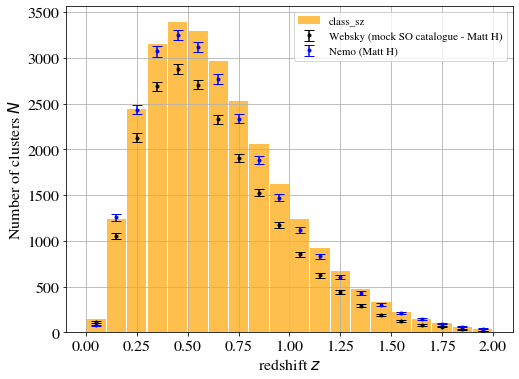

In [15]:
N_clusters_z, xedges = np.histogram(z, bins=z_edges)
fig = plt.figure()

plt.errorbar(z_center,N_clusters_z,yerr=np.sqrt(N_clusters_z),marker='o',markersize=3.,ls='none',label=r'Websky (mock SO catalogue - Matt H)',capsize=5,c='k')
#plt.hist(z_center,N_clusters_z_theory,marker='o',markersize=3.,ls=':',label='theory',c='orange')
n, bins, patches = plt.hist(x=np.repeat(z_center,N_clusters_z_theory), bins=z_edges, color='orange',alpha=0.7, rwidth=0.95,label=r'class_sz')
# n, bins, patches = plt.hist(x=np.repeat(z_center,N_clusters_z_theory_actlike), bins=z_edges, color='green',alpha=0.3, rwidth=0.95,label=r'ACT (~$10^{3}$)')
# n, bins, patches = plt.hist(x=np.repeat(z_center_planck,N_clusters_z_theory_planck), bins=z_edges_planck, color='red',alpha=0.7, rwidth=0.95,label=r'PLANCK (~$10^{2}$)')
# n, bins, patches = plt.hist(x=np.repeat(z_center,N_clusters_z_theory), bins=z_edges, color='orange',alpha=0.7, rwidth=0.95,label=r'SO (~$10^{4}$) - class_sz')
plt.errorbar(z_nemo,Nz_selfn,yerr=np.sqrt(Nz_selfn),marker='o',markersize=3.,ls='none',label=r'Nemo (Matt H)',capsize=5,c='b')





plt.grid()
plt.legend(loc=1,fontsize=11)
plt.xlabel(r'redshift $z$')
plt.ylabel(r'Number of clusters $N$')
plt.yscale('linear')
plt.show()
# plt.savefig('Nz_compare.pdf')
# plt.ylim(1e0,5e3)

In [28]:
 data.field("M200m").min()

1.4278445084810019

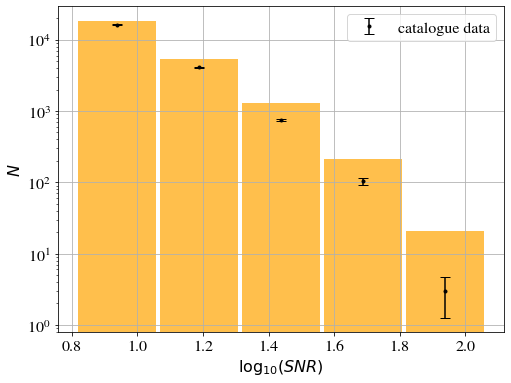

In [31]:
N_clusters_y, xedges = np.histogram(np.log10(snr), bins=log10y_edges)
plt.errorbar(log10y_center,N_clusters_y,yerr=np.sqrt(N_clusters_y),marker='o',markersize=3.,ls='none',label='catalogue data',capsize=5,c='k')
#plt.plot(log10y_center,N_clusters_y_theory,marker='o',markersize=3.,ls=':',label='theory',c='orange')
n, bins, patches = plt.hist(x=np.repeat(log10y_center,N_clusters_y_theory), bins=log10y_edges, color='orange',alpha=0.7, rwidth=0.95)


plt.grid()
plt.legend()
plt.xlabel(r'$\log_{10}(SNR)$')
plt.ylabel(r'$N$')
plt.yscale('log')
plt.show()